# Trnasfer learning of T5/mT5 model for binary classification


In [15]:
import os
import logging
import re
from pprint import pprint
from glob import glob
from hashlib import md5

import pandas as pd
import numpy as np

from tqdm import tqdm
import wandb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from scipy.special import softmax
from matplotlib import pyplot as plt
import seaborn as sns

from simpletransformers.t5 import T5Model, T5Args

In [16]:
# (optional) Login to WANDB to monitor training progress
try:
    wandb.login()
except Exception as e:
    pprint(e)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [17]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

## Prepare datasets

In [18]:
def clean_text(text):
    user_re = r"(@[\w]+)"
    link_re = r"(https?:\/\/\S+)"
    text = re.sub(user_re, "", text) # remove user tags
    text = re.sub(link_re, "", text) # remove links
    text = text.lower().strip()
    return text

def read_redit_gab(path, slitter_re):
    data = []
    for i, row in tqdm(pd.read_csv(path).iterrows()):
        hash = md5(row["id"].encode()).hexdigest()
        
        for s in slitter_re.findall(row["id"]):
            row["id"] = row["id"].replace(s, "<SEP>", 1)
            row["text"] = row["text"].replace(s, "<SEP>", 1)

        ids = [id.strip() for id in row["id"].split("<SEP>") if id.strip()]
        texts = [text.strip() for text in row["text"].split("<SEP>") if text.strip()]

        if len(ids) != len(texts):
            # print(f"[WARN] i={i}, len(ids)={len(ids)}, len(texts)={len(texts)}")
            continue

        hashes = [hash] * len(ids)

        labels = row["hate_speech_idx"]
        labels = [] if labels is np.NaN else labels
        
        labels = ["HOF" if str(x+1) in labels else "NOT" for x in range(len(ids))]
        data += list(zip(hashes, ids, texts, labels))

    data = pd.DataFrame(data, columns=["hash", "id", "input_text", "target_text"])
    data["input_text"] = data["input_text"].apply(clean_text)
    data["prefix"] = "binary classification"
    return data[["prefix", "input_text", "target_text"]]


def load_senti_news_dataset(path):
    data_df = pd.read_csv(path, sep="\t")

    data_df["input_text"] = data_df["content"].map(clean_text)
    data_df["target_text"] = data_df["avg_sentiment"].map(lambda x: "NOT" if round(float(x)) >= 3 else "HOF")
    data_df["prefix"] = "binary classification"
    data_df = data_df[["prefix", "input_text", "target_text"]]
    return data_df

train_si_df, test_si_df = train_test_split(load_senti_news_dataset("data/non-processed/dataset10/SentiNews_sentence-level.txt"), test_size=0.005)
train_si_df = train_si_df.sample(7500)


train_data_reddit, test_data_reddit = train_test_split(read_redit_gab("data/non-processed/dataset14/reddit.csv",  re.compile("(\d+\. [\\t]*)[a-z0-9]{7}\\n")),   test_size=0.2)
train_data_gab,    test_data_gab    = train_test_split(read_redit_gab("data/non-processed/dataset14/gab.csv",     re.compile("(\d+\. [\\t]*)[0-9]{8}\\n")),      test_size=0.2)

train_en_df = pd.concat([train_data_reddit, train_data_gab])
test_en_df = pd.concat([test_data_reddit, test_data_gab])

train_ml_df = pd.concat([train_en_df, train_si_df])
test_ml_df = pd.concat([test_en_df,  test_si_df])

5020it [00:01, 4551.57it/s]
11825it [00:02, 5345.31it/s]


In [19]:
def plot_class_hist(data_df, title):
    data_df["target_text"].value_counts().plot(kind="bar", title=f"Class distirbution: {title}")

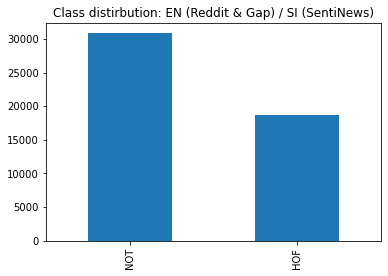

In [20]:
plot_class_hist(train_ml_df, "EN (Reddit & Gap) / SI (SentiNews)")

Since classes are unablanced we will use random under sampling to balance out class distribution

In [21]:
# def random_over_sample(df):
#     ros = RandomOverSampler()
#     X_resampled, y_resampled = ros.fit_resample(df[["prefix", "input_text"]], df["target_text"])
#     ros_df = X_resampled
#     ros_df["target_text"] = y_resampled
#     return ros_df

def random_under_sample(df):
    rus = RandomUnderSampler()
    X_resampled, y_resampled = rus.fit_resample(df[["prefix", "input_text"]], df["target_text"])
    rus_df = X_resampled
    rus_df["target_text"] = y_resampled
    return rus_df

In [22]:
train_en_df = random_under_sample(train_en_df).sample(n = 6000)
train_ml_df = random_under_sample(train_ml_df).sample(n = 6000)

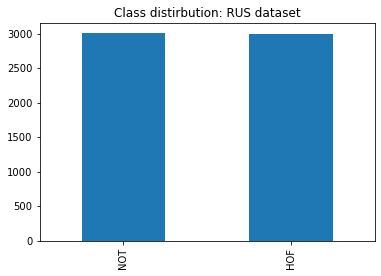

In [23]:
plot_class_hist(train_en_df, "RUS dataset")

## Train T5 models

In [24]:
def get_t5_model(model_name, hf_model_type, hf_model_name):
    model_args = T5Args()
    model_args.output_dir=f"/hdd/matjazibb/outputs/{model_name}"
    model_args.best_model_dir=f"{model_args.output_dir}/best_model"
    model_args.cache_dir=f"/hdd/matjazibb/cache_dir/{model_name}"
    model_args.tensorboard_dir=f"/hdd/matjazibb/runs/{model_name}"

    # Training HP
    model_args.fp16 = False # If True model cant be evaluated
    model_args.num_train_epochs = 1
    model_args.learning_rate = 1e-4
    model_args.train_batch_size = 1 # 12GB GPU memory is not enough
    model_args.weight_decay = 1e-4
    model_args.scheduler = "polynomial_decay_schedule_with_warmup"

    # Dataset
    model_args.lazy_loading = True # Because bigger datasets do not fit in the RAM

    # Evaluation
    model_args.evaluate_during_training = False
    model_args.evaluate_each_epoch = False

    # Outputs & cache
    model_args.save_model_every_epoch = True
    model_args.save_steps = -1
    model_args.overwrite_output_dir = True
    model_args.wandb_project = "eval-t5"

    need_training = not os.path.exists(model_args.output_dir)
    pretrained_model_name = hf_model_name if need_training else model_args.output_dir

    return need_training, T5Model(
        hf_model_type, pretrained_model_name,
        args=model_args,
        use_cuda=True,
        cuda_device=0,
    )

In [25]:
need_training, t5_en_model = get_t5_model(
    "t5_en_x6",
    "t5",
    "t5-small",
)

if need_training:
    t5_en_model.train_model(train_en_df)

In [26]:
need_training, t5_ml_model = get_t5_model(
    "t5_ml_x6",
    "t5",
    "t5-small",
)

if need_training:
    t5_ml_model.train_model(train_ml_df)

In [27]:
need_training, mt5_en_model = get_t5_model(
    "mt5_en_x6",
    "mt5",
    "google/mt5-small",
)

if need_training:
    mt5_en_model.train_model(train_en_df)

In [28]:
need_training, mt5_ml_model = get_t5_model(
    "mt5_ml_x6",
    "mt5",
    "google/mt5-small",
)

if need_training:
    mt5_ml_model.train_model(train_ml_df)

## Evaluate BERT models

In [29]:
def eval_model(model, data_df):
    to_predict = (data_df["prefix"] + ": " + data_df["input_text"]).tolist()
    y_hat = model.predict(to_predict)

    y_true = data_df["target_text"]
    p_hat = [0.0 if x == "NOT" else 1.0 for x in y_hat]

    f1 = sklearn.metrics.f1_score(y_true, y_hat, pos_label="HOF")
    precision = sklearn.metrics.precision_score(y_true, y_hat, pos_label="HOF")
    recall = sklearn.metrics.recall_score(y_true, y_hat, pos_label="HOF")
    fpr, tpr, t = sklearn.metrics.roc_curve(y_true, p_hat, pos_label="HOF")
    roc_auc = sklearn.metrics.auc(fpr, tpr)

    return f1, precision, recall, roc_auc, fpr, tpr

In [34]:
eval_models = [
    ("T5-RedditGab-en", t5_en_model, test_en_df),
    ("T5-SentiNews-si", t5_en_model, test_si_df),

    ("T5-X-en", t5_ml_model, test_en_df),
    ("T5-X-si", t5_ml_model, test_si_df),

    ("mT5-RedditGab-en", mt5_en_model, test_en_df),
    ("mT5-SentiNews-si", mt5_en_model, test_si_df),

    ("mT5-X-en", mt5_ml_model, test_en_df),
    ("mT5-X-si", mt5_ml_model, test_si_df),
]

results = []

for model_name, model, data_df in eval_models:
    f1, precision, recall, roc_auc, fpr, tpr = eval_model(model, data_df)
    results += [(model_name, f1, precision, recall, roc_auc, fpr, tpr)]

Generating outputs:   0%|          | 0/1314 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


Decoding outputs:   0%|          | 0/10510 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/106 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


Decoding outputs:   0%|          | 0/845 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1314 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


Decoding outputs:   0%|          | 0/10510 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/106 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


Decoding outputs:   0%|          | 0/845 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1314 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


Decoding outputs:   0%|          | 0/10510 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/106 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


Decoding outputs:   0%|          | 0/845 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Generating outputs:   0%|          | 0/1314 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


Decoding outputs:   0%|          | 0/10510 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/106 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


Decoding outputs:   0%|          | 0/845 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


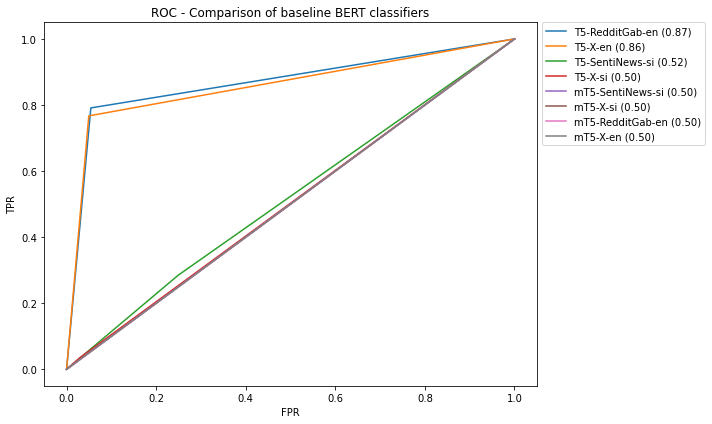

In [35]:
plt.figure(figsize=(10,6))
for model_name, f1, precision, recall, roc_auc, fpr, tpr in sorted(results, key=lambda x: x[4], reverse=True):
    plt.plot(fpr, tpr, label=f"{model_name} ({roc_auc:.2f})")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - Comparison of baseline BERT classifiers")
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0, ncol=1)
plt.tight_layout()
plt.savefig("results/eval-t5-rocs.pdf")

In [36]:
results_df = pd.DataFrame(results, columns=["model_name", "f1", "precision", "recall", "roc_auc", "fpr", "tpr"])
results_df.to_csv("results/eval-t5.csv", index=False)
results_df.head(30)

,model_name,f1,precision,recall,roc_auc,fpr,tpr
0,T5-RedditGab-en,0.840940,0.897406,0.791159,0.868503,"[0.0, 0.05415272284758138, 1.0]","[0.0, 0.7911585365853658, 1.0]"
1,T5-SentiNews-si,0.349481,0.452915,0.284507,0.517764,"[0.0, 0.24897959183673468, 1.0]","[0.0, 0.28450704225352114, 1.0]"
2,T5-X-en,0.829282,0.902541,0.767022,0.858717,"[0.0, 0.0495892911469425, 1.0]","[0.0, 0.7670223577235772, 1.0]"
3,T5-X-si,0.062992,0.461538,0.033803,0.502616,"[0.0, 0.02857142857142857, 1.0]","[0.0, 0.03380281690140845, 1.0]"
4,mT5-RedditGab-en,0.000000,0.000000,0.000000,0.499848,"[0.0, 0.000304228780042592, 1.0]","[0.0, 0.0, 1.0]"
5,mT5-SentiNews-si,0.000000,0.000000,0.000000,0.500000,"[0.0, 1.0]","[0.0, 1.0]"
6,mT5-X-en,0.000000,0.000000,0.000000,0.499848,"[0.0, 0.000304228780042592, 1.0]","[0.0, 0.0, 1.0]"
7,mT5-X-si,0.000000,0.000000,0.000000,0.500000,"[0.0, 1.0]","[0.0, 1.0]"


In [37]:
%reset